Text(0, 0.5, 'Percentage of people who are left-handed')

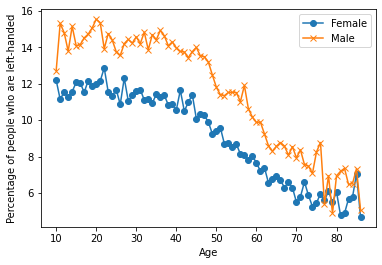

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt

# load the data
data_url_1 = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
lefthanded_data = pd.read_csv(data_url_1, sep = ',')

# plot male and female left-handedness rates vs. age
%matplotlib inline
fig, ax = plt.subplots() # create figure and axis objects
ax.plot('Age', 'Female', data = lefthanded_data, marker='o') # plot "Female" vs. "Age"
ax.plot('Age', 'Male', data = lefthanded_data, marker = 'x') # plot "Male" vs. "Age"
ax.legend() # add a legend
ax.set_xlabel("Age")
ax.set_ylabel("Percentage of people who are left-handed")

Text(0, 0.5, 'Percentage left-handed')

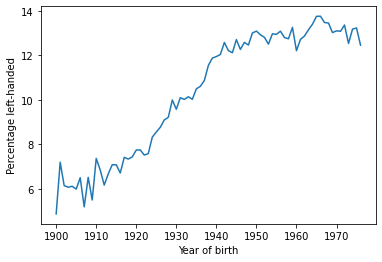

In [2]:
# create a new column for birth year of each age
lefthanded_data['Birth_year'] = 1986 - lefthanded_data['Age'] # the study was done in 1986

# create a new column for the average of male and female
lefthanded_data['Mean_lh'] = lefthanded_data[['Female', 'Male']].mean(axis = 1)

# create a plot of 'Mean_lh' vs. 'Birth_year'
fig, ax = plt.subplots()
ax.plot('Birth_year', 'Mean_lh', data = lefthanded_data)
ax.set_xlabel("Year of birth")
ax.set_ylabel("Percentage left-handed")

In [3]:
import numpy as np

# create a function for P(LH | A)
def P_lh_given_A(ages_of_death, study_year = 1990):
    """ P(Left-handed | age of death), calculated based on the reported rates of left-handedness.
    Inputs: age of death, study_year
    Returns: probability of left-handedness given that a subject died in `study_year` at age `age_of_death` """
    
    # Use the mean of the 10 neighbouring points for rates before and after the start 
    early_1900s_rate = lefthanded_data['Mean_lh'][-10:].mean()
    late_1900s_rate = lefthanded_data['Mean_lh'][:10].mean()
    middle_rates = lefthanded_data.loc[lefthanded_data['Birth_year'].isin(study_year - ages_of_death)]['Mean_lh']
    
    youngest_age = study_year - 1986 + 10 # the youngest age in the NatGeo dataset is 10
    oldest_age = study_year - 1986 + 86 # the oldest age in the NatGeo dataset is 86
    
    P_return = np.zeros(ages_of_death.shape)  # create an empty array to store the results
    # extract rate of left-handedness for people of age age_of_death
    P_return[ages_of_death > oldest_age] = early_1900s_rate / 100
    P_return[ages_of_death < youngest_age] = late_1900s_rate / 100
    P_return[np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))] = middle_rates / 100
 
    return P_return

Text(0, 0.5, 'Number of people who died')

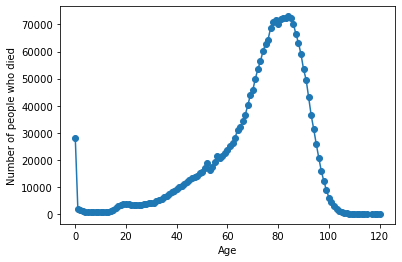

In [4]:
# Death distribution data for the United States in 1999
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"

# load death distribution data
death_distribution_data = pd.read_csv(data_url_2, sep = '\t', skiprows=[1])

# drop NaN values from the `Both Sexes` column
death_distribution_data = death_distribution_data.dropna(subset = ["Both Sexes"]) # drop NaN from'Both Sexes' column

# plot number of people who died as a function of age
fig, ax = plt.subplots()
ax.plot('Age', 'Both Sexes', data = death_distribution_data, marker='o')
ax.set_xlabel("Age")
ax.set_ylabel("Number of people who died")

In [5]:
def P_lh(death_distribution_data, study_year = 1990): # sum over P_lh for each age group
    """ Overall probability of being left-handed if you died in the study year
    P_lh = P(LH | Age of death) P(Age of death) + P(LH | not A) P(not A) = sum over ages 
    Input: dataframe of death distribution data
    Output: P(LH), a single floating point number """
    p_list = death_distribution_data['Both Sexes']*P_lh_given_A(death_distribution_data['Age'], study_year)
    p = np.sum(p_list)
    return p/np.sum(death_distribution_data['Both Sexes']) # normalize to total number of people in distribution

print(P_lh(death_distribution_data))

0.07766387615350638


In [6]:
def P_A_given_lh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / np.sum(death_distribution_data['Both Sexes'])
    P_left = P_lh(death_distribution_data, study_year) # use P_lh function to get probability of left-handedness overall
    P_lh_A = P_lh_given_A(ages_of_death, study_year) # use P_lh_given_A to get probability of left-handedness for a certain age
    return P_lh_A*P_A/P_left

In [7]:
def P_A_given_rh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / np.sum(death_distribution_data['Both Sexes'])
    P_right = 1- P_lh(death_distribution_data, study_year) # either you're left-handed or right-handed, so these sum to 1
    P_rh_A = 1-P_lh_given_A(ages_of_death, study_year) # these also sum to 1 
    return P_rh_A*P_A/P_right

Text(0, 0.5, 'Probability of being age A at death')

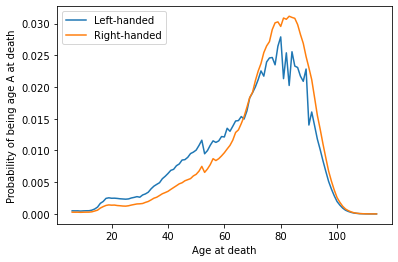

In [8]:
ages = np.arange(6,115,1) # make a list of ages of death to plot

# for each age, calculate the probability of being left- or right-handed
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)

fig, ax = plt.subplots() # create figure and axis objects
ax.plot(ages, left_handed_probability, label = "Left-handed")
ax.plot(ages, right_handed_probability, label = "Right-handed")
ax.legend()
ax.set_xlabel("Age at death")
ax.set_ylabel(r"Probability of being age A at death")

In [9]:
# calculate average ages for left-handed and right-handed groups
# use np.array so that two arrays can be multiplied
average_lh_age =  np.nansum(ages*np.array(left_handed_probability))
average_rh_age =  np.nansum(ages*np.array(right_handed_probability))

# print the average ages for each group
print(round(average_lh_age,1))
print(round(average_rh_age,1))

# print the difference between the average ages
print("The difference in average ages is " + str(round(average_rh_age - average_lh_age, 1)) + " years.")

67.2
72.8
The difference in average ages is 5.5 years.


In [10]:
# loop through ages, calculating the probability of being left- or right-handed
left_handed_probability_2018 = P_A_given_lh(ages, death_distribution_data, study_year = 2018)
right_handed_probability_2018 = P_A_given_rh(ages, death_distribution_data, study_year = 2018)
    
# calculate average ages for left-handed and right-handed groups
average_lh_age_2018 =  np.nansum(ages*np.array(left_handed_probability_2018))
average_rh_age_2018 =  np.nansum(ages*np.array(right_handed_probability_2018))

print("The difference in average ages is " + 
      str(round(average_rh_age_2018 - average_lh_age_2018, 1)) + " years.")

The difference in average ages is 2.3 years.
